# 1. Dependencies

To execute the notebook, ensure that you have a python enviornment in version 3.8. Within the directory is an included ```requirements.txt``` file which can be pip installed with all the packages utilised within this notebook.

In [8]:
import cv2
import re
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import pyttsx3
import mediapipe as mp  
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.python.client import device_lib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from string import ascii_uppercase

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) # Checks whether there is a GPU available
print(device_lib.list_local_devices()) # Lists the available devices


Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 721271896092655799
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7011009824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2555771217090062004
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# 2. Functions & Variables

Functions that were utilised throughout the program and major variables. The ```INPUT_VIDEO_PATH``` variable is where the .mp4 files where stored locally.

Sources: 
- https://github.com/nicknochnack/ActionDetectionforSignLanguage


In [9]:

INPUT_VIDEO_PATH = r'C:\Users\Tommaso\Google Drive\Current Courses\COMP9444\CodingTasks\Data'
SEQUENCE_LENGTH = 30 # How many frames are recorded
VID_SEQUENCES = 90 # No. of videos recorded at a time

mp_holistic = mp.solutions.holistic # bringing the holstic model
mp_drawing = mp.solutions.drawing_utils # drawing utilities
label_map = {} # map of the labels
no_sequences = {} # no. of videos for each action
actions = [] # ASL alphabet gestures

# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Videos are going to be 30 frames in length
SEQUENCE_LENGTH = 30

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction - detecting using mediapipe
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections
    
# CAN CHANGE THE COLOURS OF THESE TO MAKE IT DIFFERENT 
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,43,114), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(58,23,200), thickness=2, circle_radius=2)
                             ) 
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(145,45,123), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(160,66,194), thickness=2, circle_radius=2)
                             ) 

# Extracting data points
def extract_keypoints(results):
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])


# 3A. Dataset Generating 

This section is where the video files were generated for each ASL alphabet gesture. Each gesture was recorded for 30 frames (dictated by the variable ```SEQUENCE_LENGTH```) and saved as an .mp4 file within a local directory. This was then repeated 30 times (dictated by the variable ```no_sequences```) for each gesture.

In [6]:
INPUT_VIDEO_PATH = r'C:\Users\Tommaso\Google Drive\Current Courses\COMP9444\CodingTasks\Data1'

cap = cv2.VideoCapture(0)

writer_check = False

# Determine width and height of frame
width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create directory if it does not exist already
if not os.path.exists(INPUT_VIDEO_PATH):
    os.mkdir(INPUT_VIDEO_PATH)
break_check = False

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # Loop through alphabet
    for action in ascii_uppercase:
        
        # Loop through sequences aka videos
        for sequence in range(VID_SEQUENCES):
            # Loop through video length aka sequence length
            for frame_num in range(SEQUENCE_LENGTH + 1):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0:
                    name = action + '.' + str(sequence).zfill(3) + '.mp4'
                    file_path = os.path.join(INPUT_VIDEO_PATH, name)
                    if not os.path.exists(file_path):
                        writer_check = True
                        cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                        cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                        # Show to screen
                        cv2.imshow('OpenCV Feed', image)
                        cv2.waitKey(2000)
                        writer= cv2.VideoWriter(file_path, cv2.VideoWriter_fourcc(*'DIVX'), 30, (width,height))
                    else:
                        writer_check = False
                        cv2.putText(image, 'DATA ALREADY COLLECTED', (120,200), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                        cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                        cv2.imshow('OpenCV Feed', image)
                        cv2.waitKey(200)
                        break
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    writer.write(frame)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    writer.release()
                    cap.release()
                    cv2.destroyAllWindows()
                    break_check = True 
                    break
        
            if writer_check == True:
                writer.release() 
                writer_check = False
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            writer.release()
            cap.release()
            cv2.destroyAllWindows()
            break_check = True 
            break
            

    writer.release()          
    cap.release()
    cv2.destroyAllWindows()

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


# 3B. Data Gathering

From the gathered .mp4 files, these were then processed utilising googles MediaPipe Machine Learning algorithm. Utilising MediaPipe Holsitic, the hand keypoints were generated and stored within numpy arrays for each frame and then saved locally within the MP_Data directory. 

In [7]:
INPUT_VIDEO_PATH = r'C:\Users\Tommaso\Google Drive\Current Courses\COMP9444\CodingTasks\Data'

i = 0

for j, vid in enumerate(os.listdir(INPUT_VIDEO_PATH)):
    print(vid)
    if '.mp4' in vid:
        string = vid.split('.')
        action = string[0]
        sequence = int(string[1])
        cap = cv2.VideoCapture(vid)
        label_map[action] = i
        
        if action in no_sequences:
            no_sequences[action] += 1
        else:
            no_sequences[action] = 1
        i += 1
        if action not in actions:
            actions.append(action)
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            # Skips the video if the files already exist
            print('Directory Already Exists, passing file')
            continue
            
        vid_loc = os.path.join(INPUT_VIDEO_PATH,vid)
        cap = cv2.VideoCapture(vid_loc)
        # Set mediapipe model 
        with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
            # this is code for reading from a video file
            frame_num = 0
            while(cap.isOpened() and frame_num < SEQUENCE_LENGTH):
                # Read feed
                ret, frame = cap.read()
                
                if ret:
                    image, results = mediapipe_detection(frame, holistic)
                    # Draw landmarks
                    draw_styled_landmarks(image, results)
                    cv2.waitKey(1)
                    
                    # UNCOMMENT THIS TO SEE THE VIDEO DISPLAYED (THIS GREATLY INCREASES THE EXECUTION TIME OF THE PROGRAM)
                    # cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                    #                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # # # Show to screen
                    # cv2.imshow('OpenCV Feed', image)
                    
                    # NEW Export keypoints
                    keypoints = extract_keypoints(results)
                    npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                    np.save(npy_path, keypoints)
                    frame_num += 1
                else:
                    break
                
        cap.release()
        cv2.destroyAllWindows()



A.000.mp4
Directory Already Exists, passing file
A.001.mp4
Directory Already Exists, passing file
A.002.mp4
Directory Already Exists, passing file
A.003.mp4
Directory Already Exists, passing file
A.004.mp4
Directory Already Exists, passing file
A.005.mp4
Directory Already Exists, passing file
A.006.mp4
Directory Already Exists, passing file
A.007.mp4
Directory Already Exists, passing file
A.008.mp4
Directory Already Exists, passing file
A.009.mp4
Directory Already Exists, passing file
A.010.mp4
Directory Already Exists, passing file
A.011.mp4
Directory Already Exists, passing file
A.012.mp4
Directory Already Exists, passing file
A.013.mp4
Directory Already Exists, passing file
A.014.mp4
Directory Already Exists, passing file
A.015.mp4
Directory Already Exists, passing file
A.016.mp4
Directory Already Exists, passing file
A.017.mp4
Directory Already Exists, passing file
A.018.mp4
Directory Already Exists, passing file
A.019.mp4
Directory Already Exists, passing file
A.020.mp4
Directory 

KeyboardInterrupt: 

# 3. Data Preprocessing

From the collected .npy files, the data is labelled accordingly based on the letter within the ASL alphabet. The dataset is then split in training and testing dataset.

In [12]:

for letter in ascii_uppercase:
    no_sequences[letter] = VID_SEQUENCES

actions = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V' ,'W', 'X', 'Y', 'Z'] 

print(no_sequences)
print(actions)
label_map = {label:num for num, label in enumerate(actions)}
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences[action]):
        window = []
        for frame_num in range(SEQUENCE_LENGTH):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

print(label_map)
X = np.array(sequences)
y = to_categorical(labels).astype(int)
print(np.array(sequences).shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

{'A': 90, 'B': 90, 'C': 90, 'D': 90, 'E': 90, 'F': 90, 'G': 90, 'H': 90, 'I': 90, 'J': 90, 'K': 90, 'L': 90, 'M': 90, 'N': 90, 'O': 90, 'P': 90, 'Q': 90, 'R': 90, 'S': 90, 'T': 90, 'U': 90, 'V': 90, 'W': 90, 'X': 90, 'Y': 90, 'Z': 90}
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}
(2340, 30, 126)


# 4. Build and Train LSTM Neural Network

The model is defined and trained within this section based on the previously created dataset. ```model.summary()``` provides an outline of the model aswell as some of the hyper parameters.

In [13]:

print(X.shape)
actions = np.asarray(actions)
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,126)))
model.add(Dropout(0.25))
model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(Dropout(0.25))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(Dropout(0.25))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['categorical_accuracy'])


(2340, 30, 126)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            48896     
_________________________________________________________________
dropout (Dropout)            (None, 30, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 256)           328704    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 128)           197120    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64) 

In [ ]:
# RUN TO TRAIN
model.fit(X_train, y_train, epochs=1000, callbacks=[tb_callback])

In [15]:
# RUN TO LOAD WEIGHTS
model.load_weights('asl_alphabet_v1.h5')

# 5. Validating and Predicting the Model

During this section, a prediction is made utilising the model and is compared to the test data to validate whether the model is functioning correctly.

In [16]:
res = model.predict(X_test)
print(actions[np.argmax(res[20])])
print(actions[np.argmax(y_test[20])])

T
T


# 6. Model Evaluation

The accuracy of the model is evaluated based on two criteria, accuracy and a mutlilabel confusion matrix, through the use of the ```sklearn.metrics``` package.

[[[339   0]
  [  0  12]]

 [[336   0]
  [  0  15]]

 [[336   0]
  [  0  15]]

 [[341   0]
  [  0  10]]

 [[335   0]
  [  0  16]]

 [[337   0]
  [  0  14]]

 [[341   0]
  [  1   9]]

 [[331   7]
  [  1  12]]

 [[339   0]
  [  0  12]]

 [[335   0]
  [  0  16]]

 [[336   0]
  [  0  15]]

 [[345   0]
  [  0   6]]

 [[337   0]
  [  0  14]]

 [[335   0]
  [  0  16]]

 [[340   0]
  [  0  11]]

 [[337   1]
  [  2  11]]

 [[341   0]
  [  1   9]]

 [[334   0]
  [  1  16]]

 [[340   0]
  [  0  11]]

 [[339   0]
  [  0  12]]

 [[337   1]
  [  1  12]]

 [[334   0]
  [  0  17]]

 [[339   0]
  [  2  10]]

 [[338   0]
  [  0  13]]

 [[333   0]
  [  0  18]]

 [[331   0]
  [  0  20]]]
The model has an accuracy of:  0.9743589743589743


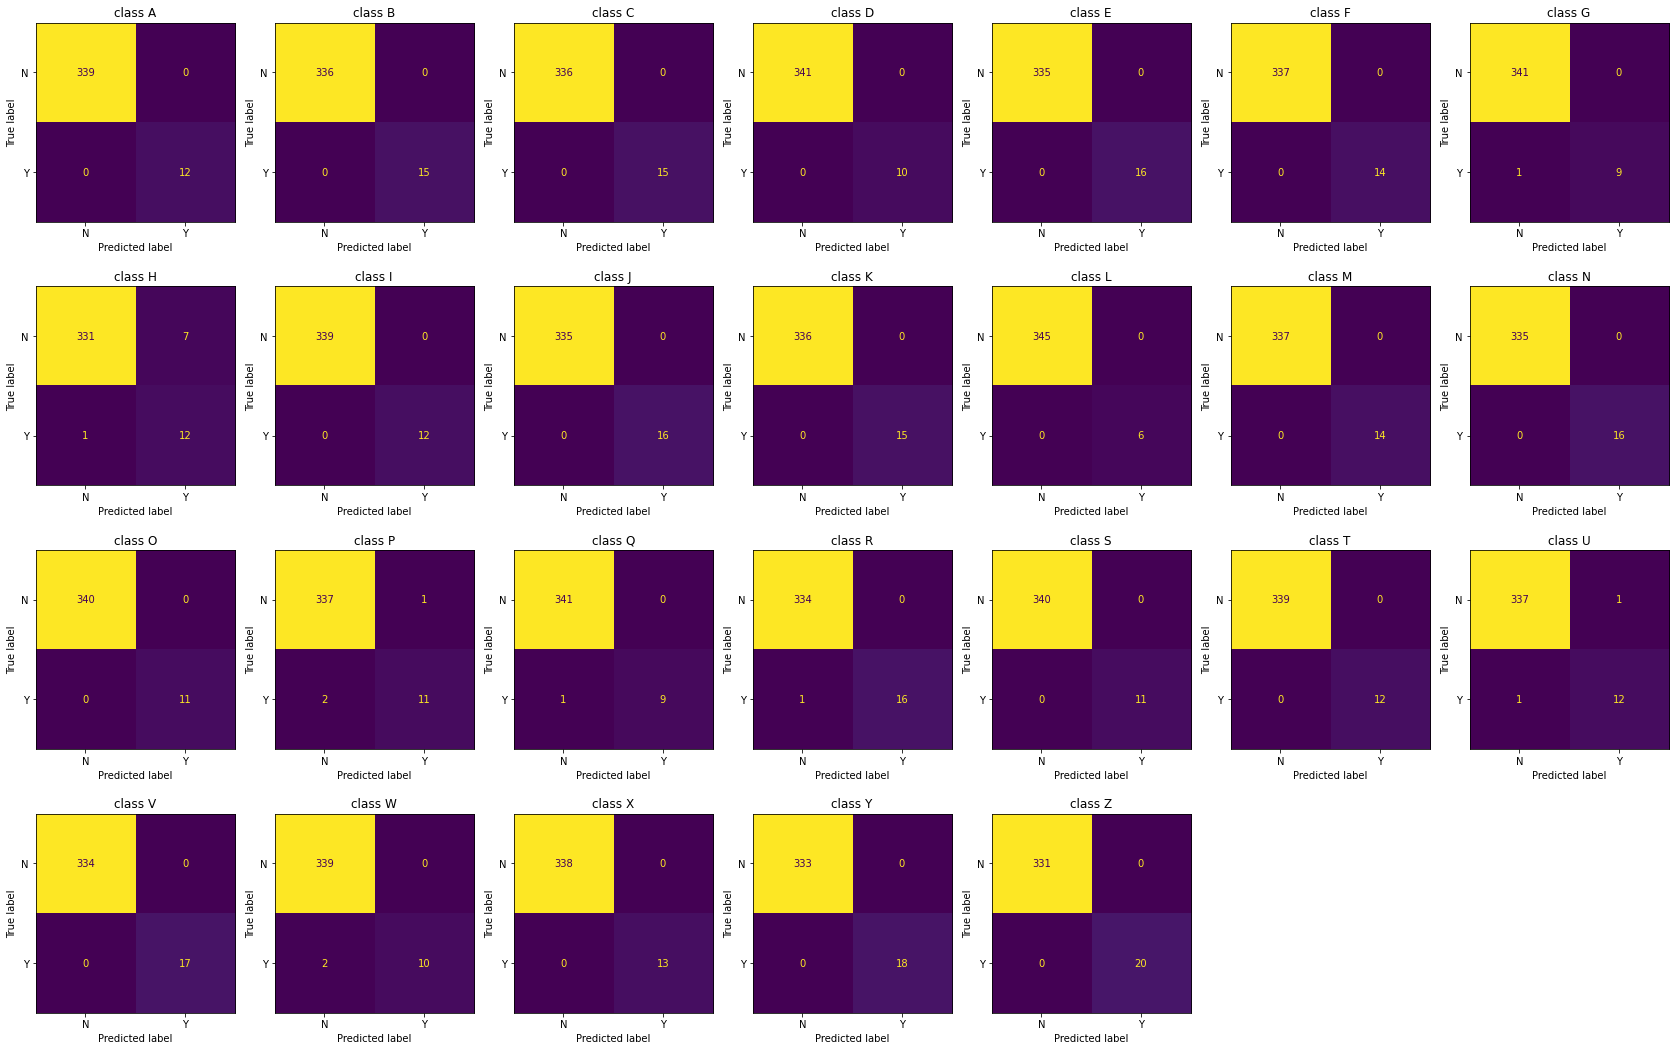

In [18]:
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
matrix_conf = multilabel_confusion_matrix(ytrue, yhat)
print(multilabel_confusion_matrix(ytrue, yhat))
print("The model has an accuracy of: ", accuracy_score(ytrue, yhat))
matrix_conf[1]
f, axes = plt.subplots(4, 7, figsize=(63, 36))
axe = axes.ravel()
for i,action in enumerate(actions):
    disp = ConfusionMatrixDisplay(matrix_conf[i],
                                  display_labels=[0, i])
    disp.plot(ax=axe[i], values_format='.4g')
    disp.ax_.set_title(f'class {action}')
    xtick_labels = [item.get_text() for item in axe[i].get_xticklabels()]
    ytick_labels = [item.get_text() for item in axe[i].get_xticklabels()]
    xtick_labels = ['N' , 'Y']
    ytick_labels = ['N' , 'Y']
    axe[i].set_xticklabels(xtick_labels)
    axe[i].set_yticklabels(ytick_labels)
    disp.im_.colorbar.remove()
f.delaxes(axe[26])
f.delaxes(axe[27])

plt.subplots_adjust(left=0, bottom=0.01, right=0.36, top=0.4)

plt.show()
    

# 7. Save Model & Loading Model

Here the model can be either saved, deleted or reloaded with another model

In [8]:
model.save('asl_alphabet_v1.h5')

In [25]:
del model

In [14]:
model.load_weights('asl_alphabet_v1.h5')

# 8. Real-time Testing

This section provides the ability to test the program in a real-time scenario. To utilise this function, run the code section and display the ASL alphabet letter you wish to detect with your right hand infront of the camera. After executing one letter, lower your hand until it is out of the view from the camera than bring it back into view to perform the next gesture. Prior to executing the code, please ensure that you have executed sections 3 & 4 first. Below is an image of the available hand gestures the model knows and their ASL meanings.

![alt text](ASL_Alphabet_Handout.jpg "ASL Alphabet")

In [31]:
# 1. New detection variables
sequence = []
sentence = []
no_hand_count = 0
threshold = 0.8
say_check = False
cap = cv2.VideoCapture(0)
letter = ""
pre_letter = ""
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        if not keypoints.any():
            no_hand_count += 1 
            if no_hand_count > 5:
                print("fuark no hads")
                sequence = []
                sentence = []
                pre_letter = ''
                letter = ''
                say_check = False
        else:
            no_hand_count = 0
            sequence.append(keypoints)
            sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold:
                pre_letter = letter
                letter =  actions[np.argmax(res)]
                print(letter)
                if len(sentence) > 0:
                    sentence = [] 
                    sentence.append(letter)
                else:
                    sentence.append(letter)
                    say_check = True

            if len(sentence) > 5: 
                sentence = sentence[-5:]
            
            print('pre letter: ', pre_letter, 'letter: ', letter)
            if sentence is not None and say_check == True and pre_letter != letter:
                text_speech = pyttsx3.init()
                text_speech.say(sentence)
                text_speech.runAndWait() # this line says it in real time
                say_check == False
            
        cv2.putText(image, ' '.join(sentence), (300,50), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        
    cap.release()
    cv2.destroyAllWindows()

fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
pre letter:   letter:  
T
pre letter:   letter:  T
T
pre letter:  T letter:  T
T
pre letter:  T letter:  T
T
pre letter:  T letter:  T
T
pre letter:  T letter:  T
T
pre letter:  T letter:  T
T
pre letter:  T letter:  T
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
O
pre letter:   letter:  O
O
pre letter:  O letter:  O
O
pre letter:  O letter:  O
O
pre letter:  O letter:  O
O
pre letter:  O letter:  O
O
pre letter:  O letter:  O
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no hads
fuark no had